### Review - ML classifier and Survival models for customer churn prediction

- Using customer data from Telco, build predictive model for consumer retention/loss:
    - Classification models (parametric and non-parametric)
    - Survival model to study time dependence of customer loss

In [ ]:
# Import analysis libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [ ]:
# Encoders for categorical data:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# CART libraries
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
# Library to plot decision tree
import graphviz

In [4]:
# Pipeline library to build ML model
from sklearn.pipeline import Pipeline, FeatureUnion

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin

class ItemSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

### Import and explore customer data:

In [6]:
telco_data_raw = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [7]:
telco_data_raw.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [8]:
telco_data_raw.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [9]:
telco_data_raw.shape

(7043, 21)

#### Check for missing data:

In [10]:
# Do we have any NA fields?
telco_data_raw.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [11]:
# Total charges is not numeric... why?
# telco_data_raw.TotalCharges.apply(pd.to_numeric) raises ValueError trying to parse " "
telco_data_raw[telco_data_raw.TotalCharges == " "].shape

# Will drop these 11 users
telco_data_processed = telco_data_raw[telco_data_raw.TotalCharges != " "].copy()
telco_data_processed.TotalCharges = telco_data_processed.TotalCharges.apply(pd.to_numeric) 

In [12]:
# Class imbalance check:
telco_data_processed[["customerID","Churn"]].groupby(["Churn"]).count()

,customerID
Churn,
No,5163
Yes,1869


In [13]:
telco_data_processed.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

#### Separate data types Categorical vs Numerical vs Target

In [14]:
# Senior citizen is numerical?
telco_data_processed.SeniorCitizen.unique()

array([0, 1])

In [15]:
# Make senior citizen str (categorical)
telco_data_processed["SeniorCitizen"] = telco_data_processed.SeniorCitizen.apply(lambda x: str(x))

In [16]:
# Extract list of categorical 
telco_categorical_features = telco_data_processed.columns[(telco_data_processed.dtypes == "object")]
telco_categorical_features = list(telco_categorical_features[(telco_categorical_features != "customerID") &
                  (telco_categorical_features != "Churn")])

telco_numerical_features = ["MonthlyCharges", "TotalCharges"]

telco_ordinal_features = ["tenure"]

target_variable = "Churn"

In [17]:
telco_categorical_features

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [18]:
telco_numerical_features

['MonthlyCharges', 'TotalCharges']

In [19]:
telco_ordinal_features

['tenure']

In [20]:
target_variable

'Churn'

## Pre-ML feature analysys

#### Explore data distributions between classes:

We can get a good idea of what features will be the most predictive for costumer churning by studying either 
the conditional probability distributions (P(X|target)) the features: 
    - For numerical features, we can study the density distributions
    - For categorical features, we study the contingency tables

In [21]:
# Define mask for target
churn_mask =  telco_data_processed.Churn == "Yes"

##### Numerical features:

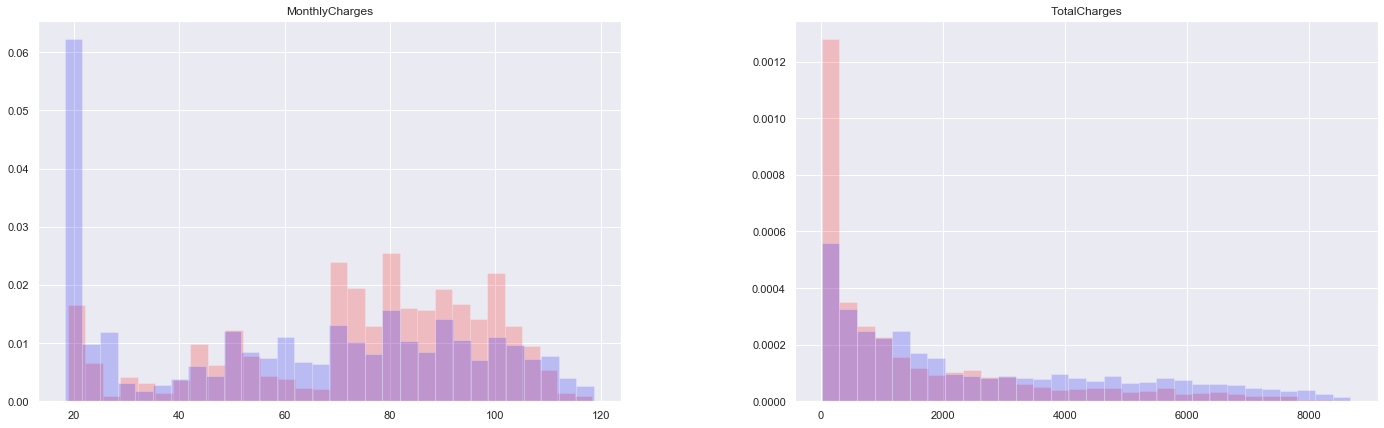

In [22]:
# Numerical features 
# Check distribution of numerical features for churn vs no-churn costumers:
# Plot p(X|Target)

fig, ax = plt.subplots(1, len(telco_numerical_features), figsize=(24, 7))

_ = telco_data_processed[churn_mask][telco_numerical_features].hist(bins=30, ax=ax, alpha=0.2, color="red", density=True)
_ = telco_data_processed[~churn_mask][telco_numerical_features].hist(bins=30, ax=ax, alpha=0.2, color="blue", density=True)

#### Ordinal Features

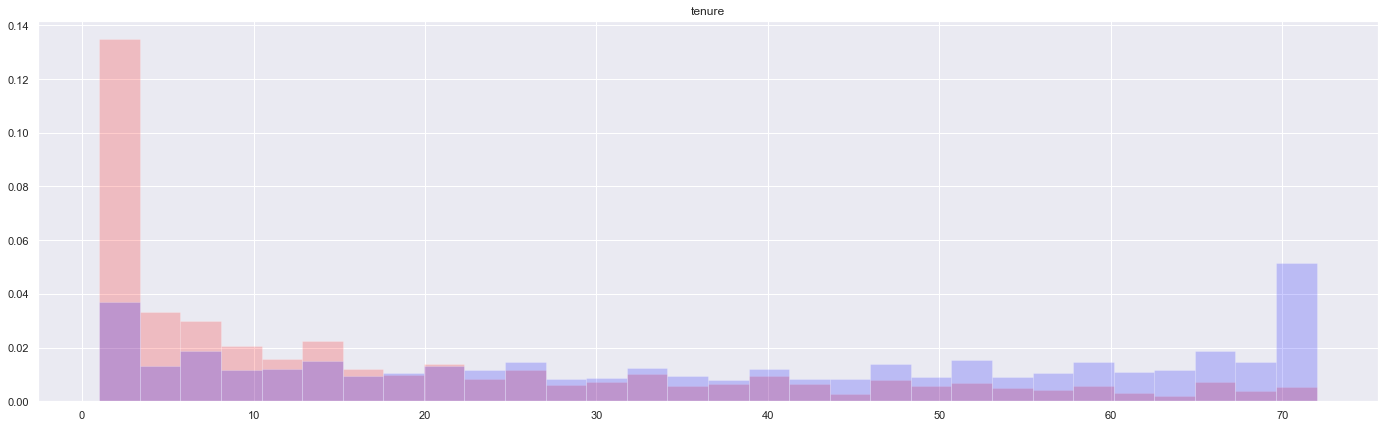

In [23]:
fig, ax = plt.subplots(1, len(telco_ordinal_features), figsize=(24, 7))

_ = telco_data_processed[churn_mask][telco_ordinal_features].hist(bins=30, ax=ax, alpha=0.2, color="red", density=True)
_ = telco_data_processed[~churn_mask][telco_ordinal_features].hist(bins=30, ax=ax, alpha=0.2, color="blue", density=True)

#### Categorical features

Study contingency tables:


Feature|Churn=Y | Churn=N |
------|------|------|
  X=0 |   $T_{0Y}$  | $T_{0N}$|
  X=1 |   $T_{1Y}$  | $T_{1N}$  |

We can calculate the conditional probabilities. E.g.:

$P_{0|Y} = \frac{T_{0Y}}{(T_{1Y}+T_{0Y})}$

For example, the contingency table for gender is:

In [24]:
pd.crosstab(index = telco_data_processed[telco_categorical_features[0]], columns=telco_data_processed[target_variable])

Churn,No,Yes
gender,,
Female,2544,939
Male,2619,930


In [25]:
pd.crosstab(index = telco_data_processed[telco_categorical_features[0]], columns=telco_data_processed[target_variable])/len(telco_data_processed)

Churn,No,Yes
gender,,
Female,0.361775,0.133532
Male,0.372440,0.132253


#### Plots of conditional probabilities:

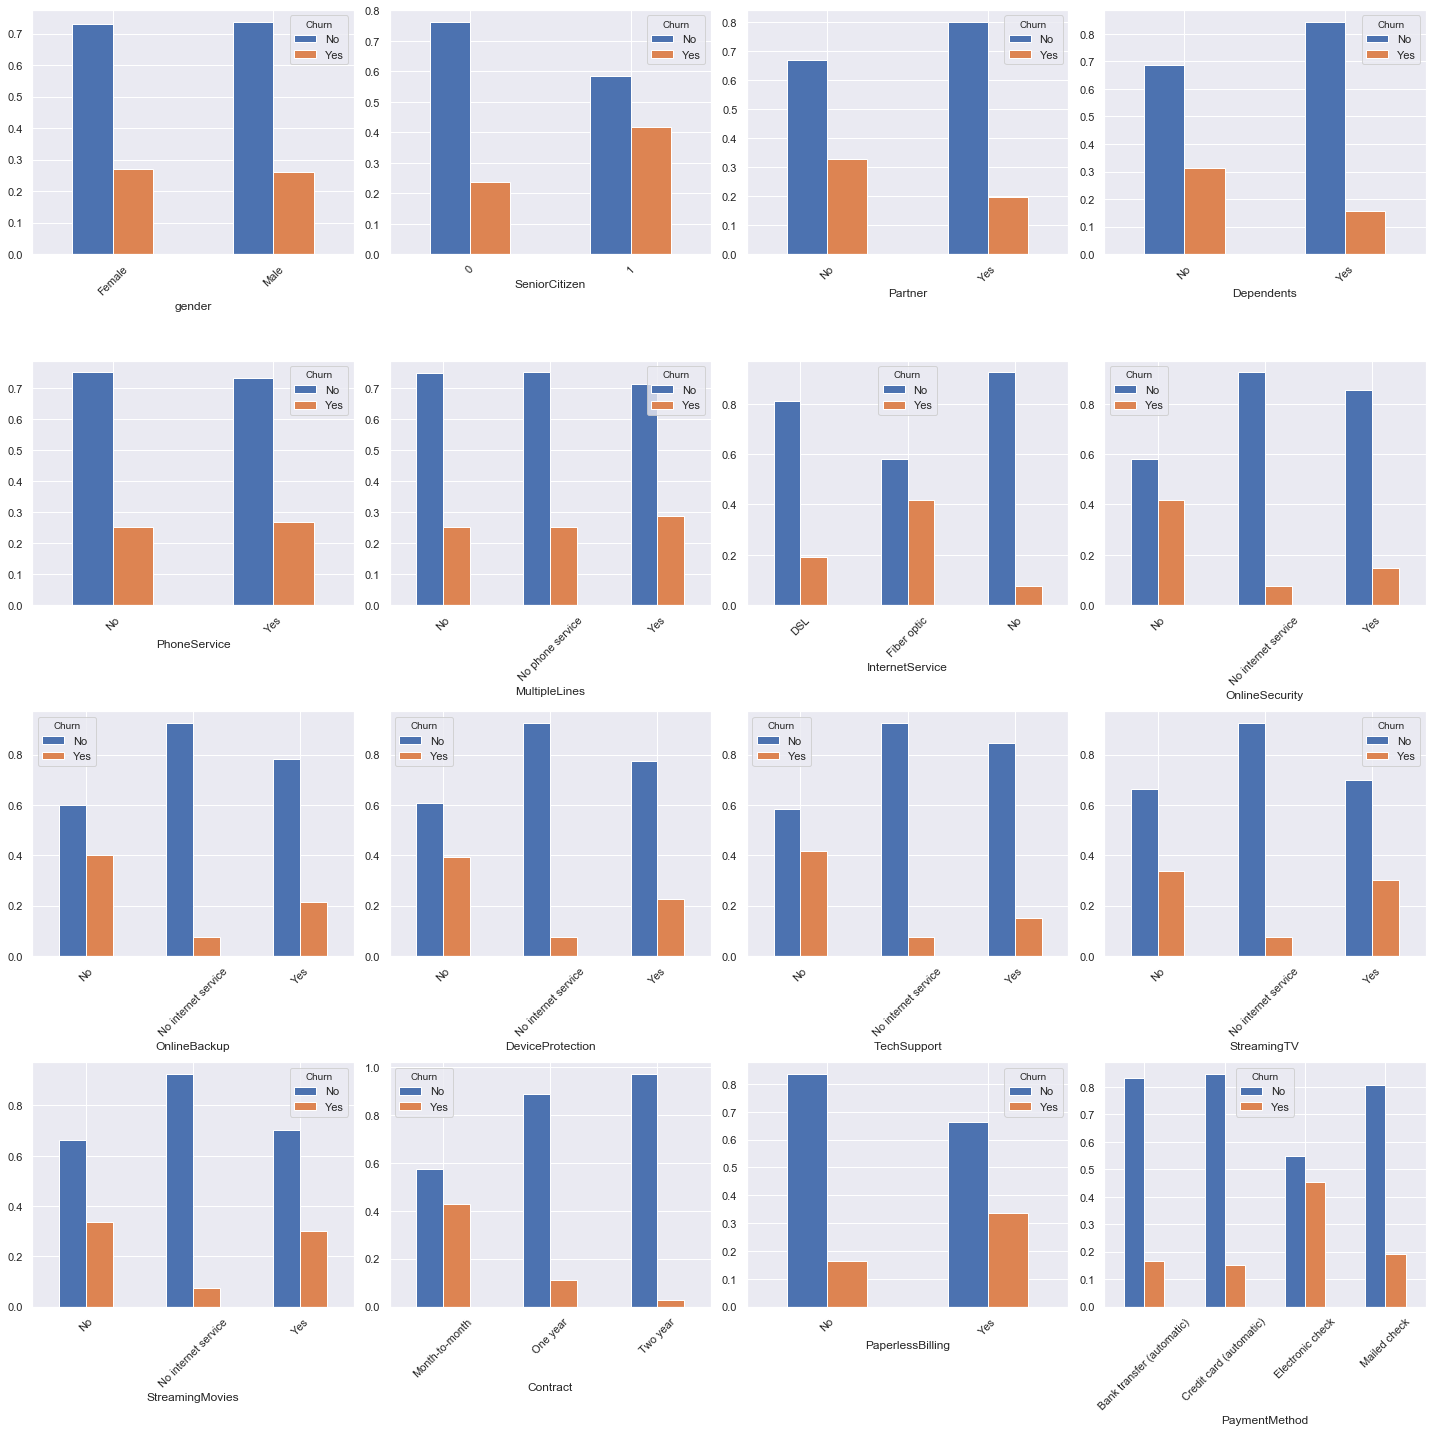

In [26]:
# Check distribution of categorical variables (using pandas bar plot):
# Note that this allows a simple comparison of the OR (odds ratio) for churning for each feature

fig, ax = plt.subplots(4,4, figsize=(20,20))
ax = ax.ravel()
for n, feature in enumerate(telco_categorical_features):
    pd.crosstab(index=telco_data_processed[feature], columns=telco_data_processed[target_variable]).apply(lambda r: r/r.sum(), axis=1).plot(ax=ax[n], kind="bar")
    ax[n].tick_params(axis='x', rotation=45)
plt.tight_layout()

In [27]:
# Also possible with seaborn:

# import seaborn as sns
# sns.set(color_codes=True)

# fig, ax = plt.subplots(4,4, figsize=(20,20))
# ax = ax.ravel()
# for n, feature in enumerate(telco_categorical_features):
#     _ = (telco_data_processed
#      .groupby(feature)[target_variable]
#      .value_counts(normalize=True)
#      .rename("proportion")
#      .reset_index()
#      .pipe((sns.catplot, 'data'), x=feature, y='proportion', hue=target_variable, ax=ax[n], kind="bar")
#     )

### Build predictive model using ML

We start by encoding the categorical variables. There are several ways of encoding,
a typical one is LabelEncoder + OneHotEncoder

In [28]:
# Start with label encoder:
# Cute, but not necessary anymore
from sklearn.preprocessing import LabelEncoder

categorical_feature_names = []
label_encoders = {}

for categorical in telco_categorical_features + [target_variable]:
    label_encoders[categorical] = LabelEncoder()
    label_encoders[categorical].fit_transform(telco_data_processed[categorical]) 
    names = label_encoders[categorical].classes_.tolist()
    print('Label encoder %s - values: %s' % (categorical, names))
    if categorical == target_variable:
        continue
    categorical_feature_names.extend([categorical + '_' + str(name) for name in names])

Label encoder gender - values: ['Female', 'Male']
Label encoder SeniorCitizen - values: ['0', '1']
Label encoder Partner - values: ['No', 'Yes']
Label encoder Dependents - values: ['No', 'Yes']
Label encoder PhoneService - values: ['No', 'Yes']
Label encoder MultipleLines - values: ['No', 'No phone service', 'Yes']
Label encoder InternetService - values: ['DSL', 'Fiber optic', 'No']
Label encoder OnlineSecurity - values: ['No', 'No internet service', 'Yes']
Label encoder OnlineBackup - values: ['No', 'No internet service', 'Yes']
Label encoder DeviceProtection - values: ['No', 'No internet service', 'Yes']
Label encoder TechSupport - values: ['No', 'No internet service', 'Yes']
Label encoder StreamingTV - values: ['No', 'No internet service', 'Yes']
Label encoder StreamingMovies - values: ['No', 'No internet service', 'Yes']
Label encoder Contract - values: ['Month-to-month', 'One year', 'Two year']
Label encoder PaperlessBilling - values: ['No', 'Yes']
Label encoder PaymentMethod - va

In [29]:
# Define transformation/fit pipeline. 
# We have both, categorical (OneHotEncode) and numerical (StandarScaler)

ppl_categorical = Pipeline([('selector', ItemSelector(key=telco_categorical_features)), 
                            ('OneHotEncoder', OneHotEncoder())])

ppl_numerical = Pipeline([('selector', ItemSelector(key=telco_numerical_features))]) #,
#                           ('Scaler', StandardScaler())])

ppl_ordinal = Pipeline([('selector', ItemSelector(key=telco_ordinal_features))])

feature_union = FeatureUnion([('categorical_features', ppl_categorical),
                              ('numerical_features', ppl_numerical),
                              ('ordinal_features', ppl_ordinal)])


ppl_clf1 = Pipeline([('feature_union', feature_union),
                         ("classifier_1", DecisionTreeClassifier(max_depth=3, random_state=42))])

ppl_clf2 = Pipeline([('feature_union', feature_union),
                         ("classifier_2", LogisticRegression())])

In [30]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(telco_data_processed, test_size=0.25, random_state=42)

ppl_clf1.fit(df_train, df_train[target_variable])
pred_1 = ppl_clf1.predict(df_test)

ppl_clf2.fit(df_train, df_train[target_variable])
pred_2 = ppl_clf2.predict(df_test)

/Users/carlosjarguello/anaconda3/envs/python_36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [31]:
from sklearn.metrics import classification_report
print(classification_report(df_test[target_variable], pred_1))
print(classification_report(df_test[target_variable], pred_2))

              precision    recall  f1-score   support

          No       0.81      0.94      0.87      1300
         Yes       0.67      0.37      0.48       458

    accuracy                           0.79      1758
   macro avg       0.74      0.65      0.67      1758
weighted avg       0.77      0.79      0.77      1758

              precision    recall  f1-score   support

          No       0.84      0.89      0.86      1300
         Yes       0.62      0.52      0.56       458

    accuracy                           0.79      1758
   macro avg       0.73      0.70      0.71      1758
weighted avg       0.78      0.79      0.79      1758



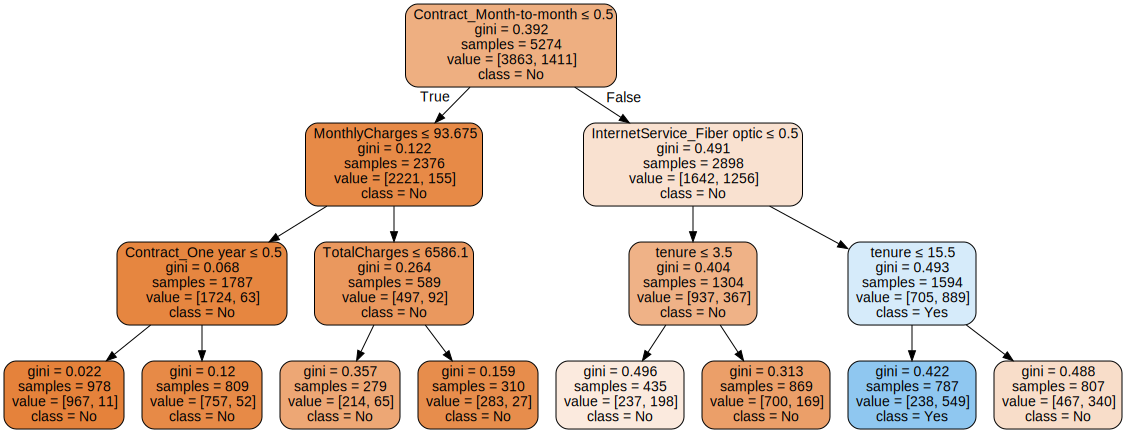

In [32]:
dot_data = tree.export_graphviz(ppl_clf1.named_steps['classifier_1'], 
                                out_file=None, 
                                feature_names = categorical_feature_names + telco_numerical_features + telco_ordinal_features,
                                class_names=[str(el) for el in ppl_clf1.named_steps.classifier_1.classes_],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data) 
graph

In [33]:
# from sklearn.linear_model import LogisticRegression 
# from sklearn.model_selection import train_test_split 
# from sklearn.metrics import confusion_matrix, accuracy_score 

# X_train, X_test, y_train, y_test = train_test_split(telco_data[x_select], data['Churn_Yes']) 
# clf = LogisticRegression(solver='lbfgs', max_iter=1000) clf.fit(X_train, y_train)

In [34]:
## Cox proportional hazards model:

from lifelines import CoxPHFitter
cph = CoxPHFitter()

In [39]:
# label encoder needed here

categorical_feature_names = []
label_encoders = {}

for categorical in telco_categorical_features + [target_variable]:
    label_encoders[categorical] = LabelEncoder()
    telco_data_processed[categorical] = label_encoders[categorical].fit_transform(telco_data_processed[categorical]) 
    names = label_encoders[categorical].classes_.tolist()
#     label_encoders[categorical] = LabelEncoder()
#     telco_data_processed[categorical] = label_encoders[categorical].fit_transform(telco_data_processed[categorical]) 
#     names = label_encoders[categorical].classes_.to_list()
    if categorical == target_variable:
        continue
    categorical_feature_names.extend([categorical + "_" + str(name) for name in names])

In [44]:
cph_train, cph_test, y_train, y_test = train_test_split(telco_data_processed[telco_categorical_features + telco_ordinal_features], telco_data_processed[target_variable], test_size=0.2) 
cph_train["Churn"] = y_train

In [45]:
cph.fit(cph_train, "tenure", "Churn")

<lifelines.CoxPHFitter: fitted with 5625 total observations, 4125 right-censored observations>

In [46]:
cph.print_summary()

In [47]:
categorical_feature_names

['gender_Female',
 'gender_Male',
 'SeniorCitizen_0',
 'SeniorCitizen_1',
 'Partner_No',
 'Partner_Yes',
 'Dependents_No',
 'Dependents_Yes',
 'PhoneService_No',
 'PhoneService_Yes',
 'MultipleLines_No',
 'MultipleLines_No phone service',
 'MultipleLines_Yes',
 'InternetService_DSL',
 'InternetService_Fiber optic',
 'InternetService_No',
 'OnlineSecurity_No',
 'OnlineSecurity_No internet service',
 'OnlineSecurity_Yes',
 'OnlineBackup_No',
 'OnlineBackup_No internet service',
 'OnlineBackup_Yes',
 'DeviceProtection_No',
 'DeviceProtection_No internet service',
 'DeviceProtection_Yes',
 'TechSupport_No',
 'TechSupport_No internet service',
 'TechSupport_Yes',
 'StreamingTV_No',
 'StreamingTV_No internet service',
 'StreamingTV_Yes',
 'StreamingMovies_No',
 'StreamingMovies_No internet service',
 'StreamingMovies_Yes',
 'Contract_Month-to-month',
 'Contract_One year',
 'Contract_Two year',
 'PaperlessBilling_No',
 'PaperlessBilling_Yes',
 'PaymentMethod_Bank transfer (automatic)',
 'Paym

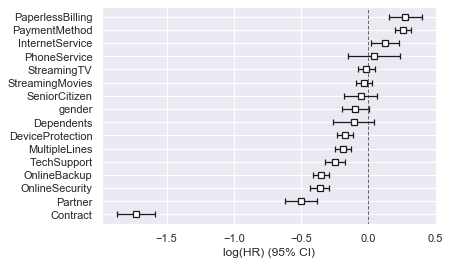

In [48]:
cph.plot()

KeyError: 'covariate `TotalCharges` is not present in the original dataset'

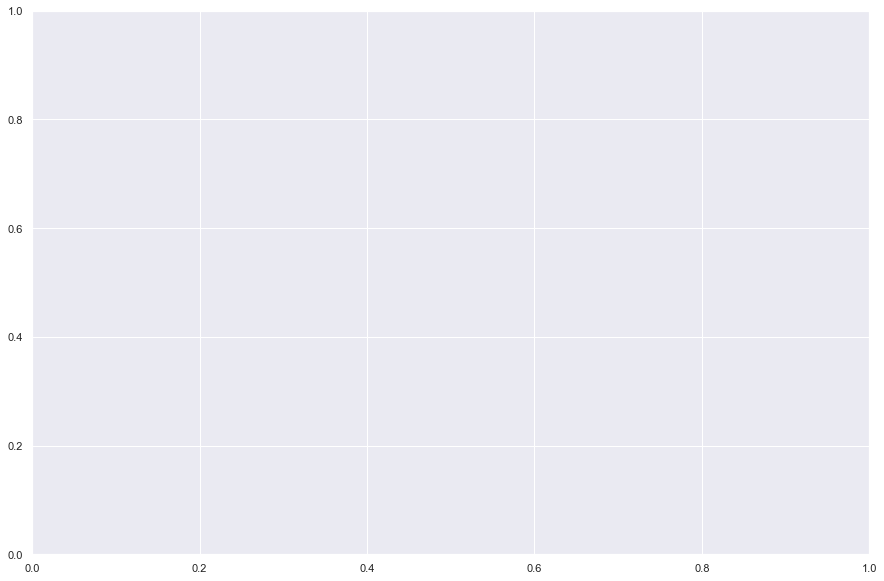

In [50]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
cph.plot_covariate_groups('TotalCharges', [0,2000, 4000], ax=ax)